# Integration with transcriptomics

In this tutorial, we will continue working with the artery datasets from the previous section to demonstrate multi-modal analysis capabilities.

The GTEx dataset provides a unique opportunity for integrative analysis as it contains paired RNA-seq and histology data for the same tissue samples.

We begin by downloading the RNA-seq data (normalized TPM matrix) and the morphological features we computed in the previous sections.

In [ ]:
from huggingface_hub import hf_hub_download

rna = hf_hub_download("rendeirolab/lazyslide-data", "GTEx_artery_RNA.h5ad", repo_type="dataset")
wsi_features = hf_hub_download("rendeirolab/lazyslide-data", "agg_conch_features.h5ad", repo_type="dataset")

In [ ]:
import anndata as ad
import scanpy as sc

rna = ad.read_h5ad(rna)
wsi_features = ad.read_h5ad(wsi_features)

/home/yzheng/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/importlib/__init__.py:90: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/data-nvme0/projects/lazyslide-tutorials/.venv/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Calcification scoring

We first examine the distribution of calcification scores across different pathological categories to understand the morphological patterns in our dataset.

<Axes: xlabel='Pathology Categories', ylabel='calcification'>

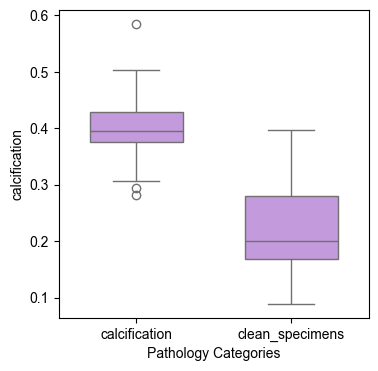

In [3]:
import seaborn as sns

sns.boxplot(
    data=wsi_features.obs,
    x="Pathology Categories",
    y="calcification",
    color="#C68FE6",
    width=0.6,
)

## Visualization of RNA and Histological morphological features

To compare the structure of our two data modalities, we will generate UMAP embeddings for both the RNA-seq data and the WSI morphological features. This visualization will help us understand how samples cluster in each modality and identify potential relationships between molecular and morphological patterns.

In [4]:
def run_umap(adata):
    sc.pp.scale(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

run_umap(rna)
run_umap(wsi_features)

/data-nvme0/projects/lazyslide-tutorials/.venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


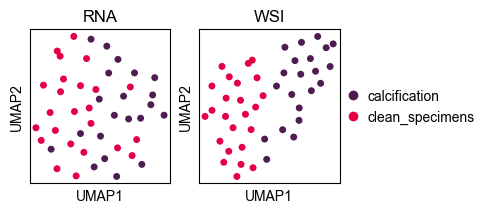

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(4, 2))
opts = dict(
    color="Pathology Categories", palette=["#4F1C51", "#E50046"], size=100, show=False
)

sc.pl.umap(rna, ax=axes[0], legend_loc=None, **opts)
sc.pl.umap(wsi_features, ax=axes[1], **opts)
axes[0].set_title("RNA")
axes[1].set_title("WSI")
plt.show(fig)

# Understanding variance across multiple modalities

Multi-Omics Factor Analysis ([MOFA](https://www.embopress.org/doi/full/10.15252/msb.20178124)) is a well-established method for identifying latent factors that explain variance across multiple data modalities. This approach allows us to decompose the variance in our RNA-seq and WSI feature data into shared and modality-specific components.

**Prerequisites:** You will need to install `muon` and `mofapy2` to execute the MOFA analysis.

In [6]:
import muon as mu

mdata = mu.MuData({"wsi": wsi_features, "rna": rna})
mu.tl.mofa(mdata, verbose=False)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


/data-nvme0/projects/lazyslide-tutorials/.venv/lib/python3.12/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/data-nvme0/projects/lazyslide-tutorials/.venv/lib/python3.12/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


Loaded view='wsi' group='group1' with N=45 samples and D=512 features...
Loaded view='rna' group='group1' with N=45 samples and D=31439 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (wsi): gaussian
- View 1 (rna): gaussian




######################################
## Training the model with seed 1 ##
######################################



Converged!



#######################
## Training finished ##
#######################


Saving model in /tmp/mofa_20250801-094415.hdf5...
Saved MOFA embeddings in .obsm['X_mofa'] slot and their loadings in .varm['LFs'].


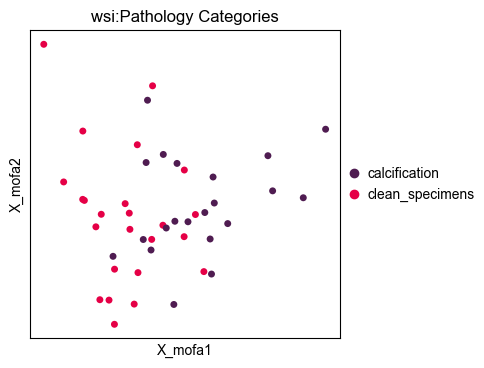

In [7]:
mu.pl.mofa(
    mdata, color="wsi:Pathology Categories", palette=["#4F1C51", "#E50046"], size=100
)

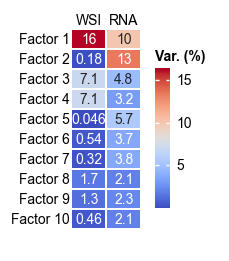

In [8]:
import numpy as np
import marsilea as ma

loadings = mdata.uns["mofa"]["variance"]

h = ma.Heatmap(
    np.array([loadings["wsi"], loadings["rna"]]).T,
    annot=True,
    cbar_kws={"width": 1, "height": 10},
    width=0.7,
    height=2,
    linewidth=0.1,
    label="Var. (%)",
)
h.add_top(ma.plotter.Labels(["WSI", "RNA"], rotation=0))
h.add_left(ma.plotter.Labels([f"Factor {i}" for i in np.arange(10) + 1]))
h.add_legends(box_padding=1)
h.render()

## Linking modalities through gene-morphology associations

To integrate WSI morphological features with bulk RNA-seq data, we employ the `RNALinker` tool to identify genes whose expression levels correlate with specific morphological features. In this case, we focus on genes associated with the calcification score, using Spearman correlation to capture monotonic relationships between gene expression and morphological patterns.

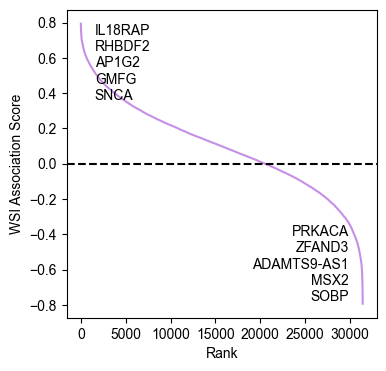

In [ ]:
import lazyslide as zs

linker = zs.tl.RNALinker(wsi_features, rna)
linker.associate(method="spearman", score_key="calcification")
linker.plot_rank(gene_name="Description") 
genes = linker.associated_genes(100, gene_name="Description")

## Functional enrichment analysis

To interpret the biological significance of genes associated with calcification, we perform functional enrichment analysis using `decoupler`. We prepare the input data by organizing the top and bottom-ranked genes (based on their association with calcification) into a matrix format suitable for pathway analysis.

In [10]:
import pandas as pd
decoupler_input = pd.concat([genes['top'], genes['bottom']]).T
decoupler_input

Description,IL18RAP,RHBDF2,AP1G2,GMFG,SNCA,PLA2G7,ENSG00000234389,NPL,ARL4C,RASAL3,...,ENSG00000268798,RBPMS2,KCTD1,MCAM,MIR325HG,PRKACA,ZFAND3,ADAMTS9-AS1,MSX2,SOBP
association_score,0.793149,0.781159,0.781028,0.780896,0.778656,0.7764,0.77632,0.774967,0.769565,0.767062,...,-0.69776,-0.699209,-0.703821,-0.731489,-0.735968,-0.744005,-0.748617,-0.753491,-0.77668,-0.793412


In [11]:
import decoupler as dc

msigdb = dc.op.resource('MSigDB')  # Use MSigDB
markers = (
    msigdb.rename(columns={"geneset": "source", "genesymbol": "target"})
    [msigdb["collection"] == "go_molecular_function"]  # Filter for GO Molecular Function
    [["source", "target"]]
    .drop_duplicates()
)

acts, padj = dc.mt.ulm(data=decoupler_input, net=markers, tmin=0)

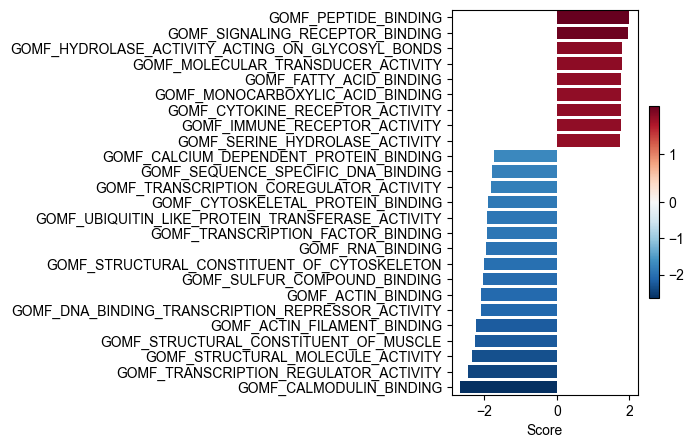

In [13]:
dc.pl.barplot(data=acts, name="association_score", top=25, figsize=(3, 5))

We can run the same analysis on RNA alone to see the difference

## Comparison: RNA-only analysis

To demonstrate the added value of integrating morphological features, we perform the same enrichment analysis using only RNA-seq data.

In [14]:
import scanpy as sc

sc.tl.rank_genes_groups(rna, "Pathology Categories", method="wilcoxon")
df = sc.get.rank_genes_groups_df(rna, "calcification").sort_values("scores")

decoupler_input_rna = pd.concat([df.head(100), df.tail(100)])[['names', 'scores']]
decoupler_input_rna['names'] = decoupler_input_rna['names'].map(rna.var['Description'].to_dict())
decoupler_input_rna = decoupler_input_rna.set_index('names').T

... storing 'Description' as categorical


In [15]:
acts, padj = dc.mt.ulm(data=decoupler_input_rna, net=markers, tmin=0)

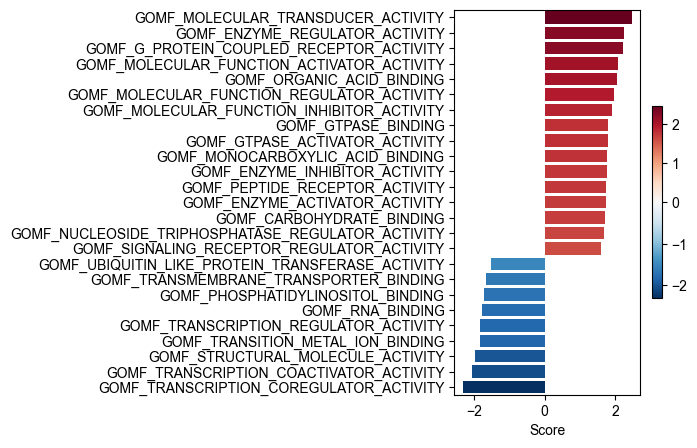

In [16]:
dc.pl.barplot(data=acts, name="scores", top=25, figsize=(3, 5))

## Conclusions

The integration of WSI morphological features with transcriptomic data yields enrichment results that are more specifically relevant to **calcification** processes. Notably, our analysis reveals functionally relevant changes such as the downregulation of **calmodulin binding** pathways.

In contrast, enrichment analysis performed solely on RNA-seq data fails to identify molecular activities that are specifically associated with calcification processes. This demonstrates the significant value of incorporating morphological features from histological images to enhance the biological interpretation of transcriptomic data.